# QLoRA applied to question answering

In [20]:
import os
import json
from collections import Counter
from tqdm import tqdm
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt

import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, set_seed, default_data_collator, get_linear_schedule_with_warmup, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType, PromptTuningConfig, PromptTuningInit
from trl import SFTTrainer
import wandb

In [2]:
os.environ["WANDB_PROJECT"] = "qlora_fingpt_finqa"
seed = 202408
set_seed(seed)

# huggingface endoints
device = "cuda"
model_name_or_path = "google/gemma-2-2b"
tokenizer_name_or_path = "google/gemma-2-2b"
dataset_name = "FinGPT/fingpt-fiqa_qa"

# Dataset
text_column = "input"

## Dataset prep

In [3]:
dataset = load_dataset(dataset_name)
# get a sample of dataset to accelerate training
#dataset = dataset["train"].train_test_split(train_size=0.1)
dataset = dataset["train"].train_test_split(test_size=0.1)
print(dataset["train"][0])

{'input': 'Can increasing my tax withholding from my full-time job cover FICA taxes for my freelance work?', 'output': "Technically you owe 'self-employment' taxes not FICA taxes because they are imposed under a different law, SECA. However, since SE taxes are by design exactly the same rates as combining the two halves of FICA (employer and employee) it is quite reasonable to treat them as equivalent. SE taxes (and income tax also) are based on your net self-employment income, after deducting business expenses (but not non-business items like your home mortgage, dependent exemptions, etc which factor only into income tax). You owe SE Medicare tax 2.9% on all your SE net income (unless it is under $400) adjusted down by 7.65% to compensate for the fact that the employer half of FICA is excluded from gross income before the employee half is computed. You owe SE Social Security tax 12.4% on your adjusted SE net income unless and until the total income subject to FICA+SECA, i.e. your W-2 

### EDA on output text lengths

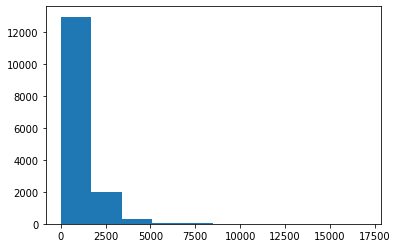

In [4]:
text_lengths = [len(sample["output"]) for sample in dataset["train"]]
plt.hist(text_lengths)
plt.show()

In [5]:
# preprocess dataset
template = """{% for message in messages %}\n{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% if loop.last and add_generation_prompt %}{{'<|im_start|>assistant\n' }}{% endif %}{% endfor %}"""
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name_or_path)
tokenizer.chat_template = template
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

/opt/homebrew/Caskroom/miniforge/base/envs/transformers/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
# model hyperparams
max_length = int(np.average(text_lengths))
target_max_length = max_length
print(f"target max length = ", target_max_length)
lr = 1e-4
num_epochs = 5
batch_size = 8

target max length =  1029


In [15]:
system_prompt, input, output = dataset["train"][0]["instruction"], dataset["train"][0]["input"], dataset["train"][0]["output"]
input_desc_formatted = f"[{input}]"
system_message = {
    "role": "system", 
    "content": f"{system_prompt}\ninput: {input_desc_formatted}\noutput: {output}"
    }
print(tokenizer.apply_chat_template([system_message], tokenize=False))

<|im_start|>system
Utilize your financial knowledge, give your answer or opinion to the input question or subject . Answer format is not limited.
input: [What is considered a business expense on a business trip?]
output: The IRS Guidance pertaining to the subject.  In general the best I can say is your business expense may be deductible.  But it depends on the circumstances and what it is you want to deduct. Travel Taxpayers who travel away from home on business may deduct related   expenses, including the cost of reaching their destination, the cost   of lodging and meals and other ordinary and necessary expenses.   Taxpayers are considered “traveling away from home” if their duties   require them to be away from home substantially longer than an   ordinary day’s work and they need to sleep or rest to meet the demands   of their work. The actual cost of meals and incidental expenses may be   deducted or the taxpayer may use a standard meal allowance and reduced   record keeping requir

In [16]:
def preprocess(samples):
    batch = []
    for system_prompt, input, output in zip(samples["instruction"], samples["input"], samples["output"]):
        try:
            input_desc_formatted = json.dumps(json.loads(f"[{input}]", indent=2, sort_keys=True))
        except:
            input_desc_formatted = f"[{input}]"
        system_message = {
            "role": "system", 
            "content": f"{system_prompt}\ninput: {input_desc_formatted}\noutput: {output}"
        }
        batch.append(tokenizer.apply_chat_template([system_message], tokenize=False))
    return {"content": batch}

In [17]:
# tokenize and preprocess dataset to be
# readable by the model as model inputs
dataset = load_dataset(dataset_name)
dataset = dataset.map(
    preprocess,
    batched=True,
    remove_columns=dataset["train"].column_names,
)
dataset = dataset["train"].train_test_split(test_size=0.1)
print(dataset["train"][0])

Map: 100%|██████████| 17110/17110 [00:00<00:00, 52677.60 examples/s]

{'content': "<|im_start|>system\nUtilize your financial knowledge, give your answer or opinion to the input question or subject . Answer format is not limited.\ninput: [Rolled over husband's 401(k) to IRA after his death. Can I deduct a loss since?]\noutput: I trust the 401(k) was a traditional, pre tax account. There was no tax paid, and any withdrawals would be taxable. The account could go to zero, and there's no write off, sorry. I have to ask - were there any withdrawals along the way? What was it invested in that lost 90% of its value?  Edit - I'm sorry the OP came and went. It would be great to have closure on some of these issues. Here, I'm thinking as Duff said, malpractice, or perhaps a 401(k) that was 100% in company stock. Seems we'll never know.<|im_end|>\n"}


In [18]:
#def test_preprocess_function(examples):
#    batch_size = len(examples[text_column])
#    inputs = [f"{text_column}: {x}\noutput" for x in examples[text_column]]
#    model_inputs = tokenizer(inputs)
#    for i in range(batch_size):
#        sample_inputs_ids = model_inputs["input_ids"][i]
#        model_inputs["input_ids"][i] = [tokenizer.pad_token_id]*(
#            max_length - len(sample_inputs_ids)
#        ) + sample_inputs_ids
#        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_inputs_ids)) + \
#            model_inputs["attention_mask"][i]
#        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
#        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
#    
#    return model_inputs

## Create PEFT model

In [10]:
# this instruction is from the dataset
#prompt_tunning_init_text = "What is the sentiment of this news? Please choose an answer from {negative/neutral/positive}. \n"
target_modules = [
    "gate_proj",
    "q_proj",
    "lm_head",
    "o_proj",
    "k_proj",
    "embed_tokens",
    "down_proj",
    "up_proj",
    "v_proj"
]

# now create peft config
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=target_modules,
    task_type=TaskType.CAUSAL_LM
)
# bits and bytes config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4", # normal bytes 4
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True # this helps saving GPU memory
)

## Define model and tokenizer

In [19]:
class ChatmlSpecialTokens(str, Enum):
    user = "<|im_start|>user"
    assistant = "<|im_start|>assistant"
    system = "<|im_start|>system"
    function_call = "<|im_start|>function-call"
    function_response = "<|im_start|>function-response"
    eos_token = "<|im_end|>"
    bos_token = "<s>"
    pad_token = "<pad>"

    @classmethod
    def list(cls):
        return [c.value for c in cls]

NameError: name 'Enum' is not defined

In [11]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    pad_token=ChatmlSpecialTokens.pad_token.value,
    bos_token=ChatmlSpecialTokens.bos_token.value,
    eos_token=ChatmlSpecialTokens.eos_token.value,
    additional_special_tokens=ChatmlSpecialTokens.list(),
    trust_remote_code=True
)
tokenizer.chat_template = template

# create model
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation="flash_attention_2"
)
model.resize_token_embeddings(len(tokenizer), pad_multiple_of=8)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 21,549,056 || all params: 7,263,281,152 || trainable%: 0.2967


## Train and eval loop

In [15]:
output_dir = "gemma2b_fingptqa"
per_device_train_batch_size = 2
per_device_eval_batch_size = 2
gradient_accumulation_steps = 4
logging_steps = 5
learning_rate = 5e-4
max_grad_norm = 1.0
num_train_epochs = 1
warmup_ratio = 0.1
lr_scheduler_type = "cosine"
max_seq_length = 2048

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    save_strategy="no",
    evaluation_strategy="epoch",
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    max_grad_norm=max_grad_norm,
    weight_decay=0.1,
    warmup_ratio=warmup_ratio,
    lr_scheduler_type=lr_scheduler_type,
    bf16=True, # set to True for quantization usage
    report_to=["tensorboard", "wandb"],
    hub_private_repo=True,
    push_to_hub=True,
    num_train_epochs=num_train_epochs,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reetrant": False}
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    packing=True,
    dataset_text_field="input",
    max_seq_length=max_seq_length,
    peft_config=peft_config,
    dataset_kwargs={
        "append_concat_token": False,
        "add_special_tokens": False
    }
)

wandb: Currently logged in as: jdgallegoq (jdgallegoq-wandb). Use `wandb login --relogin` to force relogin


100%|██████████| 960/960 [02:27<00:00,  6.53it/s]


epoch=0: train_ppl=tensor(nan, device='cuda:0') train_epoch_loss=tensor(nan, device='cuda:0') eval_ppl=tensor(nan, device='cuda:0') eval_epoch_loss=tensor(nan, device='cuda:0')


100%|██████████| 960/960 [02:26<00:00,  6.54it/s]


epoch=1: train_ppl=tensor(nan, device='cuda:0') train_epoch_loss=tensor(nan, device='cuda:0') eval_ppl=tensor(nan, device='cuda:0') eval_epoch_loss=tensor(nan, device='cuda:0')


100%|██████████| 960/960 [02:27<00:00,  6.53it/s]


epoch=2: train_ppl=tensor(nan, device='cuda:0') train_epoch_loss=tensor(nan, device='cuda:0') eval_ppl=tensor(nan, device='cuda:0') eval_epoch_loss=tensor(nan, device='cuda:0')


  1%|          | 11/960 [00:05<07:27,  2.12it/s]


KeyboardInterrupt: 

In [ ]:
trainer.train()
trainer.save_model()

## Evaluation after finetuning

In [19]:
from peft import PeftModel, PeftConfig

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> input: The parties have also agreed on options that allow UH to extensively implement later on also functionalities of human resources management .
instruction : What is the sentiment of this tweet? Please choose an answer from {negative/neutral/positive}.
output :  positive</s>


In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True
)
peft_model_id = "jdgallegq96/gemma2b_fingptqa"
device = "cuda"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation="flash_attention_2"
)
tokenizer = AutoTokenizer.from_pretrained(peft_model_id)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)
model = PeftModel.from_pretrained(model, peft_model_id)

In [ ]:
model.eval()
i = 123
inputs = tokenizer(eval_dataset[i]['input'], return_tensors="pt", add_special_tokens=False)
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.autocast(dtype=torch.bfloat16, device_type=device):
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_length,
        do_sample=True,
        top_p=0.95,
        temperature=0.2,
        repetition_penalty=1.0,
        eos_token_id=tokenizer.eos_token_id
    )
print(tokenizer.decode(outputs[0]))